<a href="https://colab.research.google.com/github/Naresh786-prog/fullstack-front/blob/main/Edgedetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cupy-cuda12x
!pip install opencv-python-headless


In [6]:
import cupy as cp
import cv2
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import PIL.Image
import io


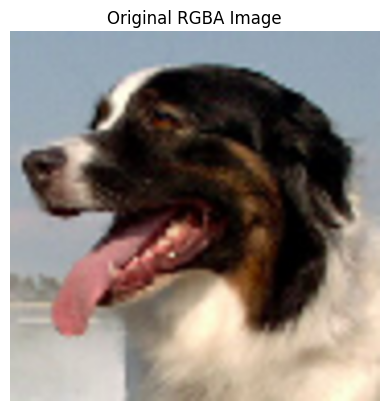

In [7]:
# Image URL
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Dog_face.png/512px-Dog_face.png'

# Load image from URL
resp = urlopen(image_url)
image = PIL.Image.open(io.BytesIO(resp.read())).convert('RGBA')

# Convert to NumPy array
image_np = np.array(image)

# Show original image
plt.imshow(image_np)
plt.title('Original RGBA Image')
plt.axis('off')
plt.show()


In [8]:
# Upload RGBA image to GPU
image_gpu = cp.asarray(image_np)

# CUDA kernel for RGBA to Grayscale
grayscale_kernel = cp.RawKernel(r'''
extern "C" __global__
void rgba_to_grayscale(unsigned char* rgba, unsigned char* gray, int width, int height) {
    int x = blockDim.x * blockIdx.x + threadIdx.x;
    int y = blockDim.y * blockIdx.y + threadIdx.y;
    if (x >= width || y >= height) return;

    int idx = (y * width + x) * 4; // RGBA
    int out_idx = y * width + x;

    unsigned char r = rgba[idx];
    unsigned char g = rgba[idx + 1];
    unsigned char b = rgba[idx + 2];

    gray[out_idx] = (unsigned char)(0.299f * r + 0.587f * g + 0.114f * b);
}
''', 'rgba_to_grayscale')

height, width, _ = image_gpu.shape
gray_gpu = cp.zeros((height, width), dtype=cp.uint8)

block = (16, 16)
grid = ((width + block[0] - 1) // block[0], (height + block[1] - 1) // block[1])

grayscale_kernel(grid, block, (image_gpu, gray_gpu, width, height))


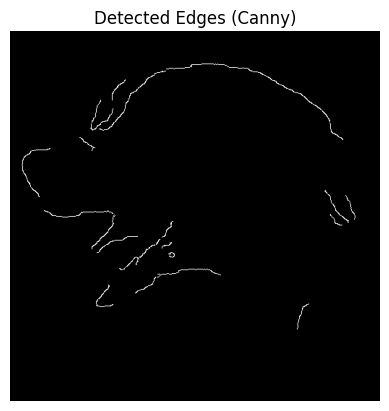

In [9]:
# Download grayscale image from GPU to CPU
gray_cpu = cp.asnumpy(gray_gpu)

# Apply Canny edge detection using OpenCV
edges = cv2.Canny(gray_cpu, threshold1=100, threshold2=200)

# Show the edge-detected image
plt.imshow(edges, cmap='gray')
plt.title('Detected Edges (Canny)')
plt.axis('off')
plt.show()


In [10]:
cv2.imwrite('/content/canny_edges_output.png', edges)


True